In [1]:
import sys
import os

abspath = r"../"
sys.path.append(os.path.abspath(abspath))

from scripts.concepts import *
from scripts.data_loader import *
from scripts.utils import *

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
dataset = Dataset_tree_cycle("./dataset", "/home/sam/Documents/network/project/dataset/d1")

In [4]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Dataset_tree_cycle(10000):
Number of graphs: 10000
Number of features: 1
Number of classes: 2

Data(x=[40, 1], edge_index=[2, 95], y=[1])
Number of nodes: 40
Number of edges: 95
Average node degree: 2.38
Has isolated nodes: False
Has self-loops: True
Is undirected: True


In [5]:
train_loader, test_loader, val_loader = create_dataloader(dataset, batch_size=60, train_prop=0.6, test_prop=0.2, val_prop=0.2)

In [6]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=20).to(device)
print(model)

GCN(
  (conv1): GCNConv(1, 20)
  (conv2): GCNConv(20, 20)
  (conv3): GCNConv(20, 20)
  (lin): Linear(in_features=20, out_features=2, bias=True)
)


In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

In [8]:

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         data = data.to(device)
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         data.to(device)
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.

for epoch in range(1, 100):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.5000, Test Acc: 0.5000
Epoch: 002, Train Acc: 0.5000, Test Acc: 0.5000


KeyboardInterrupt: 

In [9]:
print(data)

Data(x=[40, 1], edge_index=[2, 95], y=[1])


In [10]:
import networkx as nx
from torch_geometric.utils import from_networkx, to_networkx

In [18]:
datasetT = Dataset_tree_cycle("./dataset", "/home/sam/Documents/network/project/dataset/d1", AddSupernodes(concepts_list_ex))

In [23]:
data = dataset[2]
g = to_networkx(data, to_undirected=True)

Data(x=[40, 1], edge_index=[2, 92], y=[1])
data y: tensor([1])
cycle
Number of nodes: 40
Number of edges: 92
Average node degree: 2.30


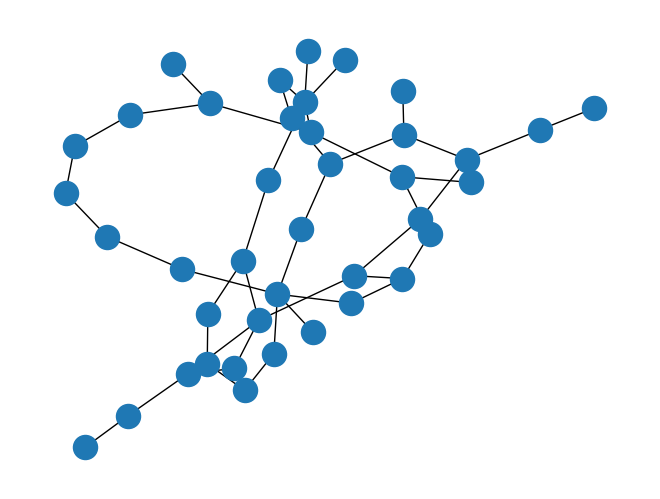

In [24]:
nx.draw(g)
print(data)
print("data y:", data.y)
try:
    c = nx.find_cycle(g)
    print("cycle")
except nx.exception.NetworkXNoCycle:
    print("nocycle")
# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')

In [25]:
dataT = datasetT[2]

In [26]:
g = to_networkx(dataT, to_undirected=True)

Data(x=[75, 1], edge_index=[2, 762], y=[1])
data y: tensor([1])
cycle
Number of nodes: 75
Number of edges: 762
Average node degree: 10.16


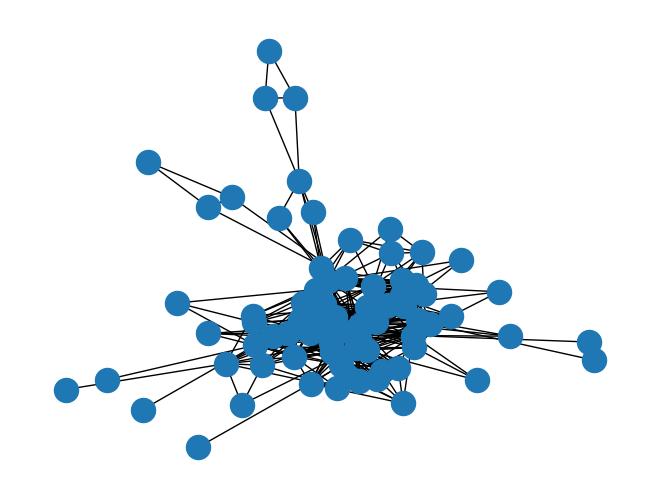

In [27]:
nx.draw(g)
print(dataT)
print("data y:", dataT.y)
try:
    c = nx.find_cycle(g)
    print("cycle")
except nx.exception.NetworkXNoCycle:
    print("nocycle")
# Gather some statistics about the first graph.
print(f'Number of nodes: {dataT.num_nodes}')
print(f'Number of edges: {dataT.num_edges}')
print(f'Average node degree: {dataT.num_edges / dataT.num_nodes:.2f}')